In [1]:
%matplotlib inline
import torch
import torchvision

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform
from PIL import Image


In [3]:
import torchvision.transforms as transforms
trans = transforms.Compose(
    [
    transforms.Normalize((0.5,), (0.5,))])

In [4]:
# Load the dataset
import os
from os import listdir
from os.path import isfile, join

class LensesDataset(list):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.files_sub = [f for f in listdir(root_dir + "/sub") if isfile(join(root_dir + "/sub", f))]
        self.files_nosub = [f for f in listdir(root_dir + "/no_sub") if isfile(join(root_dir + "/no_sub", f))]
        self.data = []
        
        assert(len(self.files_sub) == 5000)
        assert(len(self.files_nosub) == 5000)


    def __getitem__(self, idx):
        if idx >= 5000:
            img_name = os.path.join(self.root_dir + "/sub",
                                self.files_sub[idx-5000])
            image = io.imread(img_name)
            image = np.array(image)
            sample = {'image': image, 'label':1}

        else:
            img_name = os.path.join(self.root_dir + "/no_sub",
                                self.files_nosub[idx])
            image = io.imread(img_name)
            image = np.array(image)
            sample = {'image': image, 'label':0}


        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def construct(self):
        for i in range(10000):
            self.data.append(self.__getitem__(i))

In [5]:
# Load the data
lenses_dataset = LensesDataset(root_dir='lenses')

lenses_dataset.construct()
print("finished loading dataset")

finished loading dataset


9697 (150, 150) 1
6356 (150, 150) 1
7550 (150, 150) 1


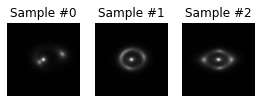

In [6]:
# inspect some of the data
import random as rand

fig = plt.figure()

count = 0
for i in range(len(lenses_dataset.data)):
    count +=1
    num = rand.randint(0, len(lenses_dataset.data))
    sample = lenses_dataset.data[num]

    print(num, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, count)
#     plt.tight_layout()
    plt.imshow(sample['image'], cmap = "gray")
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    if count == 3:
        plt.show()
        break

In [7]:
# Define the model
import torch.nn as nn
import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super(Net,self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, kernel_size=5,padding=2)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
#         self.conv3 = nn.Conv2d(16,120,kernel_size=5)
#         self.mp = nn.MaxPool2d(2)
#         self.relu = nn.ReLU()
#         self.fc1 = nn.Linear(120,84)
#         self.fc2 = nn.Linear(84,10)
#         self.logsoftmax = nn.LogSoftmax()
        
#     def forward(self,x):
#         in_size = x.size(0)
#         out = self.relu(self.mp(self.conv1(x)))
#         out = self.relu(self.mp(self.conv2(out)))
#         out = self.relu(self.conv3(out))
#         out = out.view(in_size, -1)
#         out = self.relu(self.fc1(out))
#         out = self.fc2(out)
#         return self.logsoftmax(out)
    
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool = nn.MaxPool2d(3, 3)
#         self.conv2 = nn.Conv2d(6, 16, 1)
#         self.fc1 = nn.Linear(32, 16)
#         self.fc2 = nn.Linear(16, 8)
#         self.fc3 = nn.Linear(8, 2)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 32)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 15 * 15, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 32 * 15 * 15)
#         print(x.shape)
        x = F.relu(self.fc1(x))
#         print(x.shape)
        x = F.relu(self.fc2(x))
#         print(x.shape)
        x = self.fc3(x)
#         print(x.shape)
        return x
net = Net()

In [8]:
# Inspect the summary
from torchsummary import summary
print(net)
summary(net, (1, 150, 150))

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=7200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 146, 146]             156
         MaxPool2d-2            [-1, 6, 73, 73]               0
            Conv2d-3           [-1, 16, 69, 69]           2,416
         MaxPool2d-4           [-1, 16, 34, 34]               0
            Conv2d-5           [-1, 32, 30, 30]          12,832
         MaxPool2d-6           [-1, 32, 15, 15]               0
            Linear-7            

In [9]:
# Optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = []
for i in range(10000):
    scaler.fit_transform(lenses_dataset.data[i]["image"])
    X.append(lenses_dataset.data[i]["image"])
X = np.array(X)
print(X.shape)
Y = [0 for i in range(5000)]
Y.extend([1 for i in range(5000)])
Y = np.array(Y)
print(Y.shape)

(10000, 150, 150)
(10000,)


In [11]:
# create validation set
from sklearn.model_selection import train_test_split


train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size = 0.2)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)



(((8000, 150, 150), (8000,)), ((2000, 150, 150), (2000,)))

In [12]:
# converting training images into torch format
train_x = train_x.reshape(8000, 1, 150, 150)
train_x  = torch.from_numpy(train_x).float()

train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([8000, 1, 150, 150]), torch.Size([8000]))

In [13]:
# converting validation images into torch format
val_x = val_x.reshape(2000, 1, 150, 150)
val_x  = torch.from_numpy(val_x).float()

val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([2000, 1, 150, 150]), torch.Size([2000]))

In [14]:
# Load the data
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)

trainloader = torch.utils.data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=32,      # mini batch size
    shuffle=True,               
    num_workers=2,              
)

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)

valloader = torch.utils.data.DataLoader(
    dataset=val_dataset,      # torch TensorDataset format
    batch_size=100,      # mini batch size
    shuffle=True,              
    num_workers=2,             
)

In [15]:
# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data# ["image"],  data["label"]

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)

#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 20 == 19:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.10f' %
#                   (epoch + 1, i + 1, running_loss / 20))
#             running_loss = 0.0

# print('Finished Training')

In [16]:
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

In [17]:
# Load the model for more training
net.load_state_dict(torch.load('./model.pt'))

In [18]:
n_epochs = 5

# compare overfited
train_loss_data,valid_loss_data = [],[]

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    net.train() # prep model for training
    for data, target in trainloader:
        # Move input and label tensors to the default device
#         data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() #*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    net.eval() # prep model for evaluation
    for data, target in valloader:
        # Move input and label tensors to the default device
#         data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item() #*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(100):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
        
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(valloader.dataset)
    
    # calculate train loss and running loss
    train_loss_data.append(train_loss)
    valid_loss_data.append(valid_loss)
    
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        n_epochs,
        train_loss,
        valid_loss
        ))
    print('\t\tTest Accuracy: %4d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\t\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1/5 	Training Loss: 0.005594 	Validation Loss: 0.001468
		Test Accuracy:   93% (1875/2000)
		Validation loss decreased (inf --> 0.001468).  Saving model ...
Epoch: 2/5 	Training Loss: 0.005876 	Validation Loss: 0.001389
		Test Accuracy:   93% (3750/4000)
		Validation loss decreased (0.001468 --> 0.001389).  Saving model ...
Epoch: 3/5 	Training Loss: 0.005075 	Validation Loss: 0.001524
		Test Accuracy:   93% (5612/6000)
Epoch: 4/5 	Training Loss: 0.004894 	Validation Loss: 0.001354
		Test Accuracy:   93% (7495/8000)
		Validation loss decreased (0.001389 --> 0.001354).  Saving model ...


RuntimeError: DataLoader worker (pid 81696) is killed by signal: Unknown signal: 0. 

In [ ]:
# # check for overfitting
# plt.plot(train_loss_data, label = "taining loss")
# plt.plot(valid_loss_data, label = "validation loss")
# plt.legend(frameon = False)